# Diffusion Models

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/08_diffusion/01_ddm/ddm.ipynb)

Additional References
- https://huggingface.co/blog/annotated-diffusion
- https://github.com/cloneofsimo/minDiffusion
- https://github.com/milesial/Pytorch-UNet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-colorblind")
from tqdm import tqdm
from pathlib import Path
from torchinfo import summary

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 0. Parameters

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = True

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

## 1. Prepare the Data

Download the [Oxford 102 Flower Dataset
](https://www.kaggle.com/datasets/nunenuh/pytorch-challange-flower-dataset) from Kaggle and extract it into `dataset`

```
08_diffusion
├── dataset
│   ├── test
│   ├── train
│   └── valid
└── 01_ddm.ipynb
```

In [ ]:
class RepeatedDataset(Dataset):
    def __init__(self, dataset, repetitions):
        self.dataset = dataset
        self.repetitions = repetitions

    def __len__(self):
        return len(self.dataset) * self.repetitions

    def __getitem__(self, index):
        return self.dataset[index % len(self.dataset)]
    

class FlowerDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = Path(root)
        self.transform = transform
        self.images = list(self.root.glob('**/*.jpg'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
dataset = FlowerDataset("dataset", transform=T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor()
]))

In [ ]:
means = []
stds = []
for image in tqdm(dataset):
    means.append(torch.mean(image, axis=(1, 2)))
    stds.append(torch.std(image, axis=(1, 2)))
mean = torch.mean(torch.stack(means), axis=0)
std = torch.mean(torch.stack(stds), axis=0)

100%|██████████| 8189/8189 [00:28<00:00, 285.88it/s]


In [ ]:
mean, std

(tensor([0.4355, 0.3777, 0.2880]), tensor([0.2523, 0.1975, 0.2050]))

In [ ]:
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),                      # [ 0.0, 1.0]
    T.Normalize(mean=mean, std=std)    # normalize
])

reverse_transform = T.Compose([
    T.Lambda(lambda t: t*std[:, None, None] + mean[:, None, None]),  # denormalize
    T.Lambda(lambda t: torch.clamp(t, 0.0, 1.0)),                    # [0.0, 1.0]
    T.Lambda(lambda t: t.permute(1, 2, 0)),                          # CHW -> HWC
    T.Lambda(lambda t: t * 255.),                                    # [0.0, 255.0]
    T.Lambda(lambda t: t.numpy().astype(np.uint8)),                  # [0, 255]
    T.ToPILImage(),                                                  # Array -> PIL
])

In [ ]:
dataset = FlowerDataset("dataset", transform=transform)
dataset = RepeatedDataset(dataset, DATASET_REPETITIONS)

In [ ]:
len(dataset)

40945

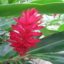

In [ ]:
idx = -1
sample = dataset[idx]
reverse_transform(sample)

In [ ]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
batch.shape

torch.Size([64, 3, 64, 64])

In [ ]:
def display(images, n=10, save_to=None):
    plt.figure(figsize=(20, 3))
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(torch.clip(images[i].permute(1, 2, 0), 0, 1))
        plt.axis("off")
    
    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")
    
    plt.show()

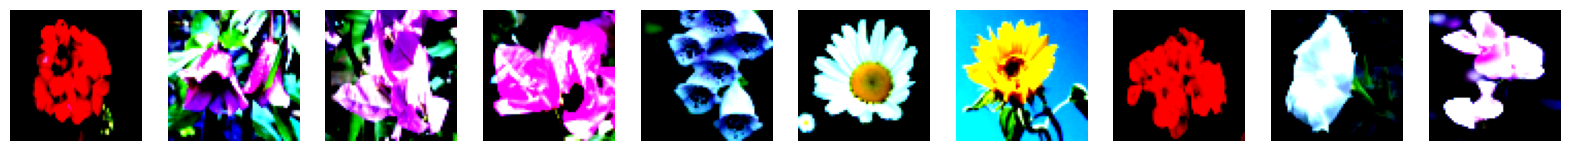

In [ ]:
display(batch)

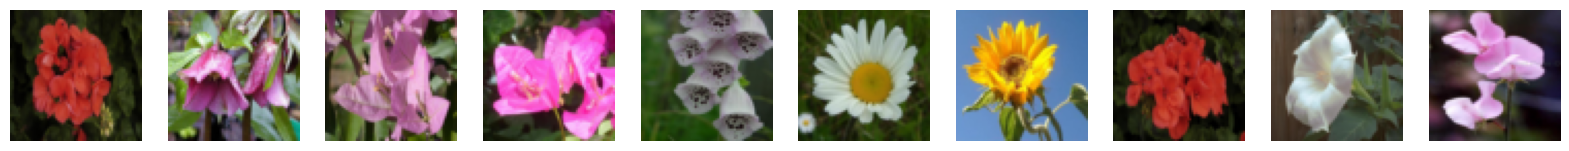

In [ ]:
display(batch*std[None, :, None, None] + mean[None, :, None, None])

### 1.1 Diffusion schedules

In [ ]:
def linear_diffusion_schedule(diffusion_times, T=1000):
    times = np.linspace(0, 1, T)

    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + times * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = np.cumprod(alphas, axis=0)
    signal_rates = np.sqrt(alpha_bars)
    noise_rates = np.sqrt(1 - alpha_bars)

    signal_rates = np.interp(diffusion_times, times, signal_rates)
    noise_rates = np.interp(diffusion_times, times, noise_rates)

    signal_rates = torch.tensor(signal_rates, dtype=torch.float32)
    noise_rates = torch.tensor(noise_rates, dtype=torch.float32)
    
    return {
        'signal_rates': signal_rates,
        'noise_rates': noise_rates,
    }

In [ ]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = torch.cos(diffusion_times * torch.pi / 2)
    noise_rates = torch.sin(diffusion_times * torch.pi / 2)
    return {
        'signal_rates': signal_rates,
        'noise_rates': noise_rates,
    }

In [ ]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = torch.math.acos(max_signal_rate)
    end_angle = torch.math.acos(min_signal_rate)
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)
    return {
        'signal_rates': signal_rates,
        'noise_rates': noise_rates,
    }

In [ ]:
T = 1000
diffusion_times = torch.linspace(0, 1, T)
linear_schedule = linear_diffusion_schedule(diffusion_times)
cosine_schedule = cosine_diffusion_schedule(diffusion_times)
offset_cosine_schedule = offset_cosine_diffusion_schedule(diffusion_times)

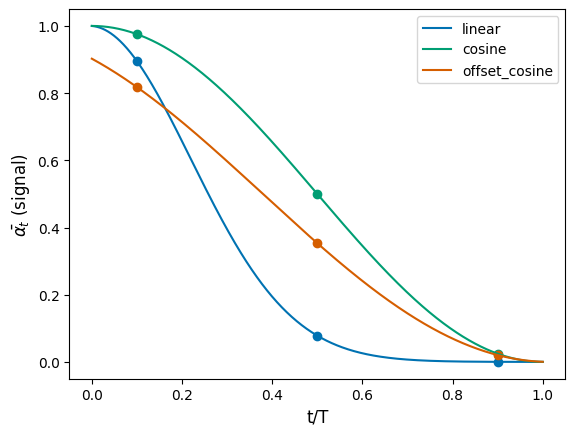

In [ ]:
plt.plot(
    diffusion_times, 
    linear_schedule['signal_rates']**2, 
    linewidth=1.5, 
    label="linear"
)
plt.plot(
    diffusion_times, 
    cosine_schedule['signal_rates']**2, 
    linewidth=1.5, 
    label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_schedule['signal_rates']**2,
    linewidth=1.5,
    label="offset_cosine",
)

points = torch.tensor([0.1, 0.5, 0.9])
plt.scatter(
    points,
    linear_diffusion_schedule(points)['signal_rates']**2,
)
plt.scatter(
    points,
    cosine_diffusion_schedule(points)['signal_rates']**2,
)
plt.scatter(
    points,
    offset_cosine_diffusion_schedule(points)['signal_rates']**2,
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

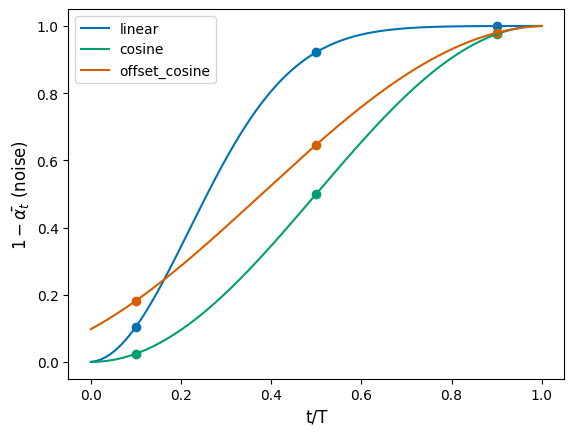

In [ ]:
plt.plot(
    diffusion_times, 
    linear_schedule['noise_rates']**2, 
    linewidth=1.5, 
    label="linear"
)
plt.plot(
    diffusion_times, 
    cosine_schedule['noise_rates']**2, 
    linewidth=1.5, 
    label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_schedule['noise_rates']**2,
    linewidth=1.5,
    label="offset_cosine",
)

points = torch.tensor([0.1, 0.5, 0.9])
plt.scatter(
    points,
    linear_diffusion_schedule(points)['noise_rates']**2,
)
plt.scatter(
    points,
    cosine_diffusion_schedule(points)['noise_rates']**2,
)
plt.scatter(
    points,
    offset_cosine_diffusion_schedule(points)['noise_rates']**2,
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize=12)
plt.legend()
plt.show()

In [ ]:
def q_sample(x_0, t, diffusion_schedule):
  diffusion_times = torch.tensor([t])
  schedule = diffusion_schedule(diffusion_times)

  # eps ~ N(0, 1)
  eps = torch.randn_like(x_0)

  signal_rates = schedule["signal_rates"]
  noise_rates = schedule["noise_rates"]

  # x_t ~ q(x_t | x_0)
  return signal_rates * x_0 + noise_rates * eps

In [ ]:
def get_noisy_image(x_0, t, diffusion_schedule):
  x_t = q_sample(x_0, t, diffusion_schedule=diffusion_schedule)
  return reverse_transform(x_t)

In [ ]:
def draw_images(imgs, save_path=None, figsize=(15, 5)):
  num_cols = len(imgs)
  fig, axs = plt.subplots(figsize=figsize, ncols=num_cols)
  for i, ax in enumerate(axs):
    ax.imshow(imgs[i])
    ax.axis('off')
  plt.tight_layout()
  if save_path:
    plt.savefig(save_path, dpi=300)
  else:
    plt.show()

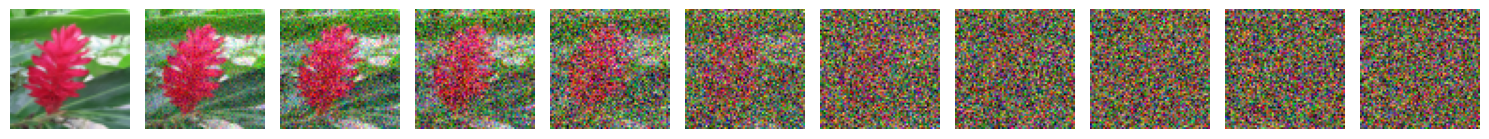

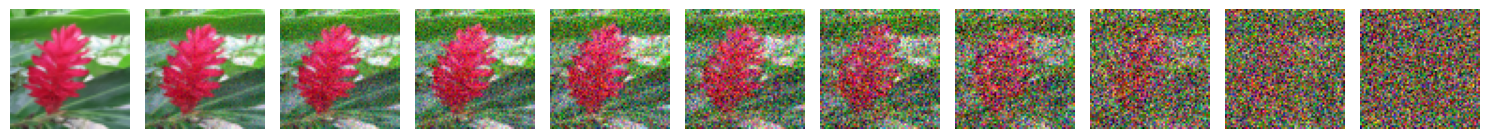

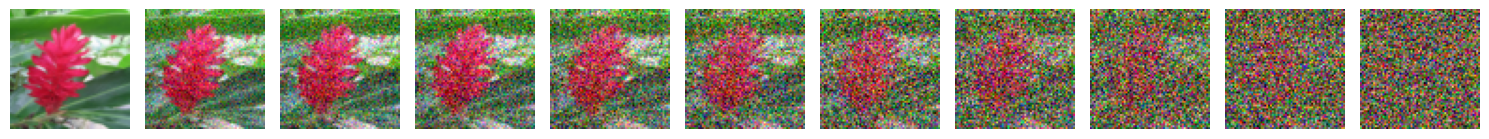

In [ ]:
time_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

xt_list_linear = [reverse_transform(sample)] +\
                 [get_noisy_image(sample, t, diffusion_schedule=linear_diffusion_schedule) 
                  for t in time_list]

xt_list_cosine = [reverse_transform(sample)] +\
                 [get_noisy_image(sample, t, diffusion_schedule=cosine_diffusion_schedule) 
                  for t in time_list]

xt_list_offset_cosine = [reverse_transform(sample)] +\
                        [get_noisy_image(sample, t, diffusion_schedule=offset_cosine_diffusion_schedule) 
                         for t in time_list]

draw_images(xt_list_linear)
draw_images(xt_list_cosine)
draw_images(xt_list_offset_cosine)

## 2. Build the model

In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dims = 32):
        super().__init__()
        self.embedding_dims = embedding_dims

    def forward(self, x):
        # x: (B,)
        
        frequencies = torch.exp(
            torch.linspace(
                torch.math.log(1.0),
                torch.math.log(1000.0),
                self.embedding_dims // 2
            )
        ).to(x.device)
        angular_speeds = 2.0 * torch.pi * frequencies
        
        # (B, 1)
        x = x.view(-1, 1)

        # (B, embedding_dims)
        embeddings = torch.cat(
            [torch.sin(angular_speeds * x), torch.cos(angular_speeds * x)], dim=-1
        )
        return embeddings

In [ ]:
y = torch.arange(0, 1, 0.01)
embedding_array = SinusoidalEmbedding(NOISE_EMBEDDING_SIZE)(y).T
embedding_array.shape

torch.Size([32, 100])

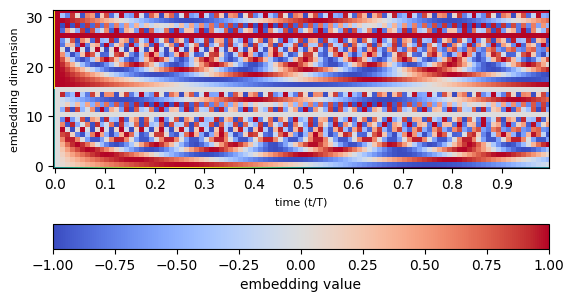

In [ ]:
fig, ax = plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("time (t/T)", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    if in_channels == out_channels:
      self.res = nn.Identity()
    else:
      self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    self.model = nn.Sequential(
      nn.BatchNorm2d(in_channels, affine=False),
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.SiLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
    )

  def forward(self, x):
    # x : (B, C_in, H, W)

    # (B, C_out, H, W)
    residual = self.res(x)

    # (B, C_out, H, W)
    x = self.model(x)

    # Residual Connection
    x = x + residual
  
    return x


class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.layers = nn.ModuleList([
      ResidualBlock(in_channels, out_channels),
      ResidualBlock(out_channels, out_channels)
    ])
    self.down = nn.AvgPool2d(2)  

  def forward(self, x, skips):
    # x : (B, C_in, H, W)

    # (B, C_out, H, W)
    for layer in self.layers:
      x = layer(x)
      skips.append(x)

    # (B, C_out, H//2, W//2)
    x = self.down(x)
    return x


class UpBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.Upsample(scale_factor=2, mode='bilinear')
    self.layers = nn.ModuleList([
      ResidualBlock(in_channels+out_channels, out_channels),
      ResidualBlock(out_channels+out_channels, out_channels)
    ])

  def forward(self, x, skips):
    # x : (B, C_in, H, W)

    # (B, C_in, H*2, W*2)
    x = self.up(x)

    # (B, C_out, H*2, W*2)
    for layer in self.layers:
      x = torch.cat([x, skips.pop()], dim=1)
      x = layer(x)
    
    return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, t_dim=NOISE_EMBEDDING_SIZE, IMG_SIZE=IMAGE_SIZE):
        super().__init__()
        
        # [B,] -> [B, 32]
        self.t_dim = t_dim
        self.time_embed = SinusoidalEmbedding(t_dim)
        self.time_up = nn.Upsample(size=(IMG_SIZE, IMG_SIZE), mode='nearest')


        # [B, C, H, H] -> [B, 32, H, H]
        self.init_conv = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)

        # [B, 64, H, H] -> [B, 32, H//2, H//2]
        self.down1 = DownBlock(64, 32)
        # [B, 32, H//2, H//2] -> [B, 64, H//4, H//4]
        self.down2 = DownBlock(32, 64)
        # [B, 64, H//4, H//4] -> [B, 96, H//8, H//8]
        self.down3 = DownBlock(64, 96)

        # [B, 96, H//8, H//8] -> [B, 128, H//8, H//8]
        self.res1 = ResidualBlock(96, 128)
        # [B, 128, H//8, H//8] -> [B, 128, H//8, H//8]
        self.res2 = ResidualBlock(128, 128)

        # [B, 128, H//8, H//8] -> [B, 128, H//4, H//4]
        # [B, 128, H//4, H//4] + [B, 96, H//4, H//4] -> [B, 96, H//4, H//4]
        # [B,  96, H//4, H//4] + [B, 96, H//4, H//4] -> [B, 96, H//4, H//4]
        self.up1 = UpBlock(128, 96)
        # [B, 96, H//4, H//4] -> [B, 96, H//2, H//2]
        # [B, 96, H//2, H//2] + [B, 64, H//2, H//2] -> [B, 64, H//2, H//2]
        # [B, 64, H//2, H//2] + [B, 64, H//2, H//2] -> [B, 64, H//2, H//2]
        self.up2 = UpBlock(96, 64)
        # [B, 64, H//2, H//2] -> [B, 64, H, H]
        # [B, 64, H, H] + [B, 32, H, H] -> [B, 32, H, H]
        # [B, 32, H, H] + [B, 32, H, H] -> [B, 32, H, H]
        self.up3 = UpBlock(64, 32)

        # [B, 32, H, H] -> [B, C, H, H]
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)
        nn.init.zeros_(self.final_conv.weight)
        nn.init.zeros_(self.final_conv.bias)

    
    def forward(self, x, t):
        # x : [B, C, H, H]
        # t : [B,]

        #------------------------------------------------------------
        # [B, 32, H, H]
        x = self.init_conv(x)

        # [B, 32, 1, 1]
        temb = self.time_embed(t).view(-1, self.t_dim, 1, 1)
        # [B, 32, H, H]
        temb = self.time_up(temb)

        # [B, 64, H, H]
        x = torch.cat([x, temb], dim=1)
        #------------------------------------------------------------

        skips = []
        # [B, 32, H//2, H//2]
        x = self.down1(x, skips)  # [B, 32, H, H], [B, 32, H, H]
        # [B, 64, H//4, H//4]
        x = self.down2(x, skips)  # [B, 64, H//2, H//2], [B, 64, H//2, H//2]
        # [B, 96, H//8, H//8]
        x = self.down3(x, skips)  # [B, 96, H//4, H//4], [B, 96, H//4, H//4]

        # [B, 128, H//8, H//8]
        x = self.res1(x)
        # [B, 128, H//8, H//8]
        x = self.res2(x)

        # [B, 96, H//4, H//4]
        x = self.up1(x, skips)
        # [B, 64, H//2, H//2]    
        x = self.up2(x, skips)
        # [B, 32, H, H]
        x = self.up3(x, skips)

        # [B, C, H, H]
        x = self.final_conv(x)

        return x

In [ ]:
eps_model=UNet(3, 3)
eps_model.to(device);

In [ ]:
summary(eps_model, input_size=[sample.unsqueeze(0).shape, [1]])

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 3, 64, 64]            --
├─Conv2d: 1-1                                 [1, 32, 64, 64]           896
├─SinusoidalEmbedding: 1-2                    [1, 32]                   --
├─Upsample: 1-3                               [1, 32, 64, 64]           --
├─DownBlock: 1-4                              [1, 32, 32, 32]           --
│    └─ModuleList: 2-1                        --                        --
│    │    └─ResidualBlock: 3-1                [1, 32, 64, 64]           29,792
│    │    └─ResidualBlock: 3-2                [1, 32, 64, 64]           18,496
│    └─AvgPool2d: 2-2                         [1, 32, 32, 32]           --
├─DownBlock: 1-5                              [1, 64, 16, 16]           --
│    └─ModuleList: 2-3                        --                        --
│    │    └─ResidualBlock: 3-3                [1, 64, 32, 32]           57,536
│    │ 

In [ ]:
def p_sample(eps_model, n_sample, size, diffusion_steps, diffusion_schedule, device, x_t=None):
    # size = (C, H, W)
    # x_T ~ N(0, 1)
    # (n_sample, C, H, W)
    x_t = torch.randn(n_sample, *size).to(device) if x_t is None else x_t

    # diffusion_steps = T
    dt = 1.0 / diffusion_steps

    for t in range(diffusion_steps):
        # (n_sample,)
        diffusion_times = torch.ones(n_sample) - t * dt
        diffusion_times = diffusion_times.to(device)
        schedule = diffusion_schedule(diffusion_times)
        signal_rates = schedule["signal_rates"].to(device)
        noise_rates = schedule["noise_rates"].to(device)

        # (n_sample, C, H, W)
        eps = eps_model(x_t, diffusion_times)

        # predicted images
        # (n_sample, C, H, W)
        pred_images = (x_t - noise_rates[:, None, None, None] * eps) / signal_rates[:, None, None, None] 
        
        # (n_sample,)
        next_diffusion_times = diffusion_times - dt
        next_schedule = diffusion_schedule(next_diffusion_times)
        next_signal_rates = next_schedule["signal_rates"].to(device)
        next_noise_rates = next_schedule["noise_rates"].to(device)
        
        # next noisy images
        # (n_sample, C, H, W)
        x_t = next_signal_rates[:, None, None, None] * pred_images + next_noise_rates[:, None, None, None] * eps

    return pred_images

torch.Size([10, 3, 64, 64])


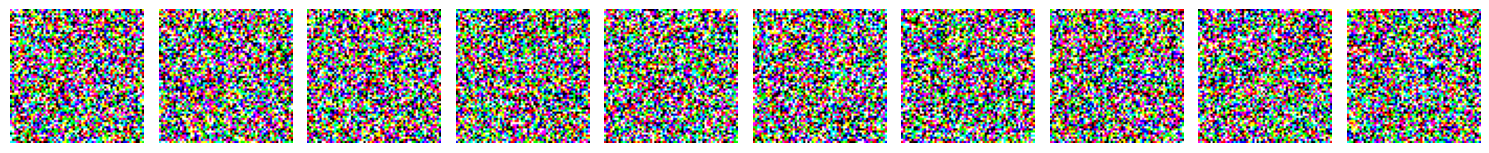

In [ ]:
eps_model.eval()
with torch.inference_mode():
    xh = p_sample(eps_model, 
                  n_sample=10, size=sample.shape, 
                  diffusion_steps=PLOT_DIFFUSION_STEPS, 
                  diffusion_schedule=offset_cosine_diffusion_schedule,
                  device=device)
    print(xh.shape)
    xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
    draw_images(xh_list)

## 3.Train the model

In [ ]:
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn

ema_model = AveragedModel(eps_model, multi_avg_fn=get_ema_multi_avg_fn(EMA))

In [ ]:
optimizer = torch.optim.AdamW(eps_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

diffusion_schedule = offset_cosine_diffusion_schedule
criterion=nn.MSELoss()

n_epoch = EPOCHS
for epoch in range(n_epoch):
  eps_model.train()

  pbar = tqdm(dataloader)
  pbar.set_description("Epoch {:>2d}/{:2d}".format(epoch+1, n_epoch))
  for x in pbar:
    # x : x_0
    # (B, C, H, W)
    x = x.to(device)
    
    # eps ~ N(0, 1)
    # (B, C, H, W)
    eps = torch.randn_like(x).to(device)

    # t ~ Uniform(0, 1)
    # (B,)
    t = torch.rand(x.shape[0]).to(device)

    # Noise Schedule
    # (B,)
    schedule = diffusion_schedule(t)
    signal_rates = schedule["signal_rates"].to(device)
    noise_rates = schedule["noise_rates"].to(device)

    # x_t ~ q(x_t | x_0)
    # (B, C, H, W)
    x_t = signal_rates[:, None, None, None] * x + noise_rates[:, None, None, None] * eps

    # Optimization
    optimizer.zero_grad()
    loss = criterion(eps, eps_model(x_t, t))
    loss.backward()
    optimizer.step()

    pbar.set_postfix_str("loss {:.4f}".format(loss.item()))

    ema_model.update_parameters(eps_model)

  ema_model.eval()
  with torch.inference_mode():
    xh = p_sample(ema_model, 
                  n_sample=10, size=sample.shape, 
                  diffusion_steps=PLOT_DIFFUSION_STEPS, 
                  diffusion_schedule=diffusion_schedule,
                  device=device)
    xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
    output_dir = Path("output")
    if not output_dir.exists(): output_dir.mkdir(exist_ok=True, parents=True) 
    draw_images(xh_list, save_path=output_dir/"epoch_{:03d}.png".format(epoch+1))
    plt.close()
    model_dir = Path("model")
    if not model_dir.exists(): model_dir.mkdir(exist_ok=True, parents=True) 
    torch.save(eps_model.state_dict(), model_dir/"model.pth")
    torch.save(ema_model.state_dict(), model_dir/"ema_model.pth")

Epoch 50/50: 100%|██████████| 640/640 [03:35<00:00,  2.98it/s, loss 0.0477]


## 4. Inference

EMA Model


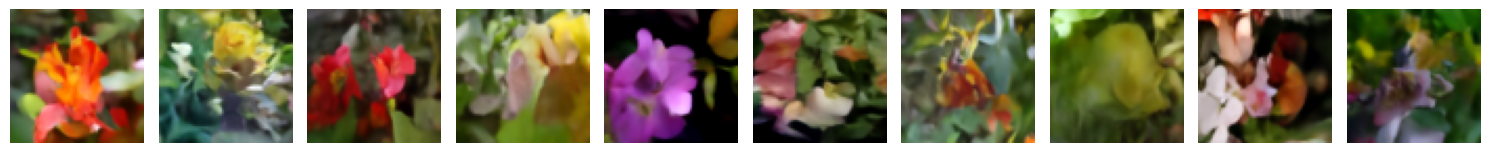

Model


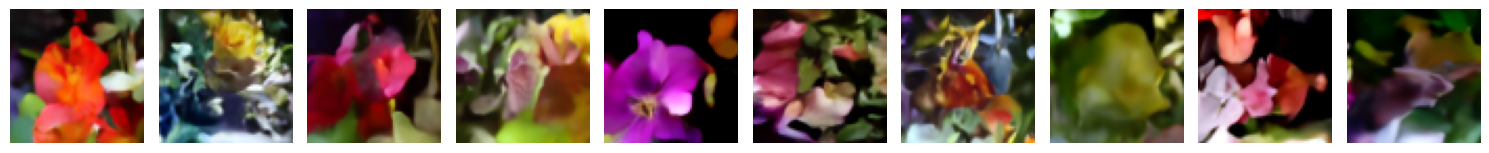

In [ ]:
n_sample = 10
size = sample.shape
x_T = torch.randn(n_sample, *size).to(device)

ema_model.eval()
with torch.inference_mode():
    xh = p_sample(ema_model, 
                  n_sample=n_sample, size=sample.shape, 
                  diffusion_steps=PLOT_DIFFUSION_STEPS, 
                  diffusion_schedule=offset_cosine_diffusion_schedule,
                  device=device,
                  x_t=x_T)
    print("EMA Model")
    xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
    draw_images(xh_list)

eps_model.eval()
with torch.inference_mode():
    xh = p_sample(eps_model, 
                  n_sample=n_sample, size=sample.shape, 
                  diffusion_steps=PLOT_DIFFUSION_STEPS, 
                  diffusion_schedule=offset_cosine_diffusion_schedule,
                  device=device,
                  x_t=x_T)
    print("Model")
    xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
    draw_images(xh_list)

EMA Model


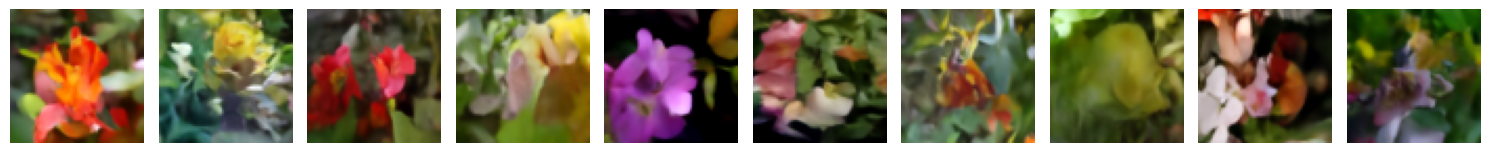

Model


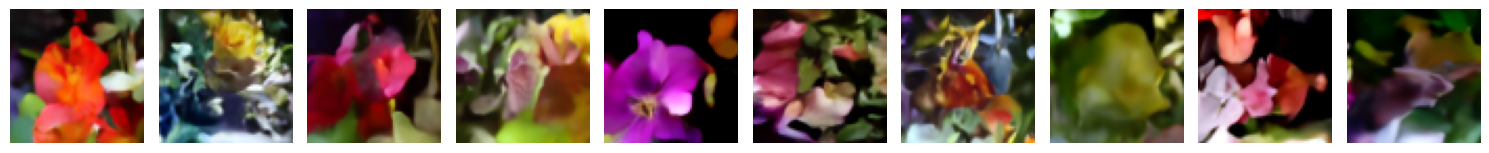

In [ ]:
if LOAD_MODEL:
    model_ema = AveragedModel(UNet(3, 3).to(device), multi_avg_fn=get_ema_multi_avg_fn(EMA))
    model_ema.load_state_dict(torch.load(model_dir/"ema_model.pth", map_location=device, weights_only=True))
    model_ema.eval()
    with torch.inference_mode():
        xh = p_sample(model_ema, 
                      n_sample=10, size=sample.shape, 
                      diffusion_steps=PLOT_DIFFUSION_STEPS, 
                      diffusion_schedule=offset_cosine_diffusion_schedule,
                      device=device,
                      x_t=x_T)
        print("EMA Model")
        xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
        draw_images(xh_list)

    model = UNet(3, 3).to(device)
    model.load_state_dict(torch.load(model_dir/"model.pth", map_location=device, weights_only=True))
    model.eval()
    with torch.inference_mode():
        xh = p_sample(model, 
                      n_sample=10, size=sample.shape, 
                      diffusion_steps=PLOT_DIFFUSION_STEPS, 
                      diffusion_schedule=offset_cosine_diffusion_schedule,
                      device=device,
                      x_t=x_T)
        print("Model")
        xh_list = [reverse_transform(xh[i].cpu()) for i in range(xh.shape[0])]
        draw_images(xh_list)